## Load a pair of images and the ground truth calibration.

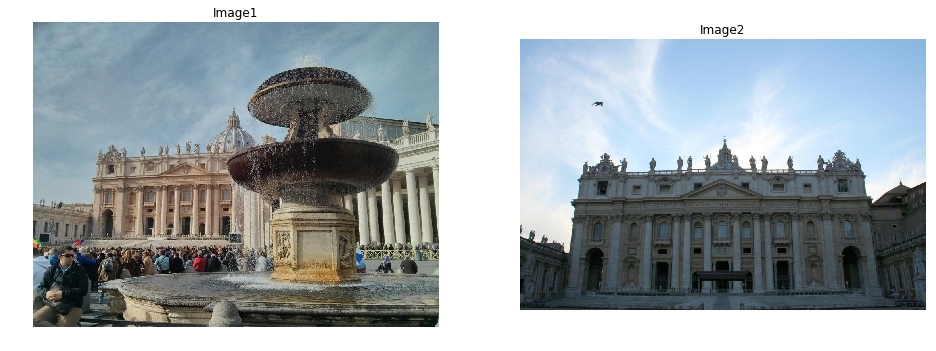

In [2]:
import sys
sys.path.insert(0, "..")

import cv2
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from demo_util import extract_corrs, visualize_corrs

# Read given images

# A sample from st_peters_square in the dataset of CNe
img1_fn, img2_fn = "img1.jpg", "img2.jpg"
img1 = cv2.cvtColor(cv2.imread(img1_fn), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread(img2_fn), cv2.COLOR_BGR2RGB)

# Read ground_truth calibration
with h5py.File("calibration_gt.h5", "r") as f:
    dR = np.array(f["dR"]) # Relative R
    dt = np.array(f["dt"]) # Relative t

    # K consists of the cx, cy and focal length.
    # Note that cx and cy could be also obtained via image size.
    K1 = np.array(f["K1"]) # Intrinsics for image 1
    K2 = np.array(f["K2"]) # Intrinsics for image 2

# Show two images
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(16, 8, forward=True)
ax1.imshow(img1)
ax1.set_title('Image1')
ax1.set_axis_off()
ax2.imshow(img2)
ax2.set_title('Image2')
ax2.set_axis_off()
plt.show()


## Generate Putative Correspondences

We use SIFT to create the correspondences between two images. Note that we use the bidirectional check to further improve the performance in the test phase.

In [3]:
# Generate Putative Correspondences, i.e., the input of CNe/ACNe
corrs = extract_corrs(img1, img2, bi_check=True, numkp=2000)
print("The # of correspondences: {}".format(len(corrs)))

The # of correspondences: 533


## Wrapper functions for ACNe/CNe
### Func `prepare_xs()`: 
It is used to calibrate or normalize the input correspondences in original image coordinates. The case of F requires the input coordinates normalized. The case of E requires the input coordinates calibrated. 

We provide two options for normalizing input coordinates: 1), normalize with std/mean of input points; 2), normalize with image size. In our paper, we normalize coordinates with the image size.


### Class `NetworkTest`: 
It is a wrapper for CNe/ACNe. We need to instantiate the class with proper parameters `config` and the path of trained model `model_path`. It allows for computing E/F by invoking function `NetworkTest.compute_E()` with input of prepared `xs` using `prepare_xs()`. 



In [4]:
from demo_util import get_T_from_K, norm_points_with_T
from utils import norm_points
from network import MyNetwork

def prepare_xs(xs, K1, K2, use_fundamental=0):
    """
    Prepare xs for model
    Inputs:
        xs: Nx4, Input correspondences in original image coordinates
        K: 3x3, Calibration matrix
        use_fundamental:
            0 means E case, xs is calibrated; 
            1 means F case, xs is normalized with mean, std of coordinates;
            2 means F case, xs is normalized with image size.
    Returns:
        xs: Nx4, Input correspondences in calibrated (E) or normed (F) coordinates
        T: 3x3, Transformation matrix used to normalize input in the case of F. None in the case of E.
    """
    x1, x2 = xs[:,:2], xs[:,2:4]
    if use_fundamental>0:
        # Normalize Points
        if use_fundamental == 1:
            # normal normalization
            x1, T1 = norm_points(x1)
            x2, T2 = norm_points(x2)
        elif use_fundamental == 2:
            # we used img_size normization
            T1 = get_T_from_K(K1)
            T2 = get_T_from_K(K2)
            x1 = norm_points_with_T(x1, T1)
            x2 = norm_points_with_T(x2, T2)
        else:
            raise NotImplementedError
        xs = np.concatenate([x1,x2],axis=-1).reshape(-1,4)
    else:
        # Calibrate Points with intrinsics
        x1 = (
            x1 - np.array([[K1[0,2], K1[1,2]]])
            ) / np.array([[K1[0,0], K1[1,1]]])
        x2 = (
            x2 - np.array([[K2[0,2], K2[1,2]]])
            ) / np.array([[K2[0,0], K2[1,1]]])
        xs = np.concatenate([x1,x2],axis=-1).reshape(-1,4)
        T1, T2 = None, None

    return xs, T1, T2


class NetworkTest(MyNetwork):

    def __init__(self, config, model_path):
        super(NetworkTest, self).__init__(config)
        
        # restore from model_path
        self.saver_best.restore(self.sess, model_path)
        
    def compute_E(self, xs):
        """
        Compute E/F given a set of putative correspondences. The unit weight vector 
        for each correspondenece is also given.
        Input:
            xs: BxNx4
        Output:
            out_e: Bx3x3
            w_com: BxN
            socre_local: BxN
        """
        _xs = np.array(xs).reshape(1, 1, -1, 4)
        feed_dict = {
            self.x_in: _xs,
            self.is_training: False, 
        }
        fetch = {
            "w_com": self.last_weights,
            "score_local":self.last_logit,
            "out_e": self.out_e_hat
        }
        res = self.sess.run(fetch, feed_dict=feed_dict)
        batch_size = _xs.shape[0]
        score_local = res["score_local"] # 
        w_com = res["w_com"] # Combined weights
        out_e = res["out_e"].reshape(batch_size, 3, 3)
        return out_e, w_com, score_local

Successfully import magsac
Successfully import usac
Successfully import pyransac
Successfully import pygcransac


## Example config, model_path

In this part, we show examples of config, model_path to instantiate the class `NetworkTest`. We tweak parameters here to determine which model we want to evaluate. We provide options including CNe_E, CNe_F, ACNe_E and ACNe_F

In [5]:
from config import get_config, print_usage

config, unparsed = get_config()

paras = {
    "CNe_E":{
        "bn_opt":"bn"},
    "ACNe_E":{
        "gcn_opt":"reweight_vanilla_sigmoid_softmax",  "bn_opt":"gn",
        "weight_opt":"sigmoid_softmax"},
    "CNe_F":{
        "bn_opt":"bn", "use_fundamental":2},
    "ACNe_F":{
        "gcn_opt":"reweight_vanilla_sigmoid_softmax",  "bn_opt":"gn",
        "weight_opt":"sigmoid_softmax", "use_fundamental":2},
}
para = paras["ACNe_F"]
for k, v in para.items():
    setattr(config, k, v)

# Model of ACNe_F trained with outdoor dataset.
model_path = "../logs/main.py---gcn_opt=reweight_vanilla_sigmoid_softmax---bn_opt=gn---weight_opt=sigmoid_softmax---loss_multi_logit=1---use_fundamental=2---data_name=oan_outdoor/models-best"
use_fundamental = config.use_fundamental # E:0, F:2.

# Instantiate warpper class
net = NetworkTest(config, model_path)

Building Graph
(?, 1, ?, 4)
(?, 1, ?, 128)
Instructions for updating:
keep_dims is deprecated, use keepdims instead
(?, ?, ?, 128)
(?, ?, ?, 128)
(?, ?, ?, 128)
(?, ?, ?, 128)
(?, ?, ?, 128)
(?, ?, ?, 128)
(?, ?, ?, 128)
(?, ?, ?, 128)
(?, ?, ?, 128)
(?, ?, ?, 128)
(?, ?, ?, 128)
(?, ?, ?, 128)
(?, ?)
X shape = (?, ?, 9)
wX shape = (?, ?, 9)
XwX shape = (?, 9, 9)
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Matchnet/hidden-input/self-conv/weights:0
Matchnet/hidden-0/conv-branch/conv1/self-conv/weights:0
Matchnet/hidden-0/conv-branch/conv1/reweight/weights:0
Matchnet/hidden-0/conv-branch/conv2/self-conv/weights:0
Matchnet/hidden-0/conv-branch/conv2/reweight/weights:0
Matchnet/hidden-1/conv-branch/conv1/self-conv/weights:0
Matchnet/hidden-1/conv-branch/conv1/reweight/weights:0
Matchnet/hidden-1/conv-branch/conv2/self-conv/weights:0
Matchnet/hidden-1/conv-branch/conv2/reweight/weights:0
Matchnet/hidden-2/conv-branch/conv1/self-conv/weights:0
Matchnet/hidden-2/c

## Run model

The model takes in the putative correspondences and outputs E/F matrix. At the same time, we provide two types of weight indicating the importance of correspondences.

- `score_local`: score for local attention -- The `sigmoid` function turns the score_local into the local attention. In the case of CNe, we should use `score_local`.

- `w_com`: combined weight a.k.a, the blended attention in our paper. Note that sum of `w_com` is 1. So we resort to the proper thresholds to determine the inliers.

With the proper threshold, the combined weight is better than the score for local attention. But the downside is that we probably need to tweak the threshold to test on new dataset of different style.



num inlier defined by score for local attention: 106


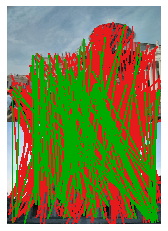

num inlier defined by combined weights: 43


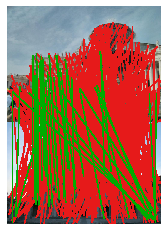

In [6]:
# Prepare input. 
xs, T1, T2 = prepare_xs(
    corrs, K1, K2, use_fundamental)
xs = np.array(xs).reshape(1, 1, -1, 4)# reconstruct a batch. Bx1xNx4

# Compute Essential/Fundamental matrix
E, w_com, score_local = net.compute_E(xs)
E = E[0]
score_local = score_local[0]
w_com = w_com[0]

# Inlier defined by score_local
mask_local = score_local > 0
print("num inlier defined by score for local attention: {}".format(
    np.sum(mask_local)))
visualize_corrs(img1, img2, corrs, mask_local)

# Inlier defined by combined weights
mask_com = w_com > 1e-5 # E: 1e-7, F: 1e-5 for OANet dataset which uses 2k SIFT.
print("num inlier defined by combined weights: {}".format(
    np.sum(mask_com)))
visualize_corrs(img1, img2, corrs, mask_com)

## Evaluation of E/F

We turn E/F into the relative R and t and compare with ground truth. We use the angular error.


In [7]:
from tests import eval_nondecompose

# Get Essential Matrix
if use_fundamental > 0:
    # In F case, we need to convert F back into E with K and T:
    # i.e., E = K2t*T2t*F*T1*K1
    E = np.dot(np.dot(T2.T, E), T1)
    E = np.dot(np.dot(K2.T, E), K1)
    
# Calibrate Points with K
p1s = corrs[:, :2]
p2s = corrs[:, 2:]
p1s = (p1s - np.array([K1[0, 2], K1[1, 2]])) / np.array([K1[0, 0], K1[1, 1]])
p2s = (p2s - np.array([K2[0, 2], K2[1, 2]])) / np.array([K2[0, 0], K2[1, 1]])

# Get q_err and t_err
err_q, err_t, _, _, _, _ = eval_nondecompose(p1s, p2s, E, dR, dt, score_local)
print("err_q: %3f degree, err_t:%3f degree" % (err_q * 180.0 / np.pi, err_t * 180.0 / np.pi))

err_q: 3.938521 degree, err_t:9.095247 degree
